In [1]:
import data
import glob
import matplotlib.pyplot as plt
import models
import numpy as np
import os
import pandas as pd
import pypickle
from strategy import Strategy
import time

from data import * 
from feature_engineering import FeaturesEngineering
from models import Models
from io import StringIO
from IPython.display import display
from sklearn.linear_model import LassoCV
from utils import log

2025-03-02 19:28:22.606700: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 19:28:22.617093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740914902.629210   16783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740914902.632814   16783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 19:28:22.645521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
models = Models(use_xgboost_gpu=True)

# Initializing the FeaturesEngineering obj
feat = FeaturesEngineering()
# Default config
feat.default_config

dict_data = {}
dict_cv_features = {}

In [3]:
dir_project = os.getcwd()
dir_models = os.path.join(dir_project, 'models')
dir_models_base = os.path.join(dir_project, 'models', 'base')
dir_models_scaler = os.path.join(dir_project, 'models', 'scaler')
dir_models_best = os.path.join(dir_project, 'models', 'best')

print(f"""
Project directory: {dir_project}
Models directory: {dir_models}
Base models directory: {dir_models_base}
Scalers directory: {dir_models_scaler}
Best models directory: {dir_models_best}
""")


Project directory: /home/alfred/projects/mscfe-masters-project/src
Models directory: /home/alfred/projects/mscfe-masters-project/src/models
Base models directory: /home/alfred/projects/mscfe-masters-project/src/models/base
Scalers directory: /home/alfred/projects/mscfe-masters-project/src/models/scaler
Best models directory: /home/alfred/projects/mscfe-masters-project/src/models/best



# Read new unseen test data

In [4]:
# Define S3 bucket and file path
bucket_name = 'mscfe-capstone-project-bucket'
file_key = 'filtered_data.csv'

filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)
display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,AMZN,BNBUSDT,0.877059,-3.631203,0.005192,True,-3.545100,0.028601,True
3,AMZN,TRXUSDT,0.814577,-3.869803,0.002269,True,-3.387413,0.043768,True
4,SPY_ETF,AVAXUSDT,0.847292,-3.309927,0.014441,True,-3.698512,0.018406,True
5,SPY_ETF,ETHUSDT,0.862483,-3.428205,0.010034,True,-3.737367,0.016394,True
6,EQQQ_ETF,BNBUSDT,0.886060,-3.816404,0.002744,True,-3.670509,0.019987,True
7,BNBUSDT,ADAUSDT,0.901459,-3.279504,0.015820,True,-3.775562,0.014607,True
8,BNBUSDT,BTCUSDT,0.884604,-2.909961,0.044202,True,-3.393160,0.043116,True
9,BNBUSDT,TRXUSDT,0.933562,-3.656380,0.004770,True,-4.003675,0.007095,True


In [5]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
file_key = 'df_full_test.csv'
df_full = pd.read_csv(file_key).drop(['Unnamed: 0'], axis=1)
# obj = s3.get_object(Bucket=bucket_name, Key=file_key)
# df_full = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8'))).drop(['Unnamed: 0'], axis=1)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
AMZN BNBUSDT
AMZN TRXUSDT
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT BTCUSDT
BNBUSDT TRXUSDT
BNBUSDT XRPUSDT
********************
Unique tickers:
META
AMZN
SPY_ETF
EQQQ_ETF
BNBUSDT
DAXEX_ETF
TRXUSDT
AVAXUSDT
ETHUSDT
ADAUSDT
BTCUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
3802,2025-01-24 10:10:00,830.7000,830.70,830.7000,830.7000,FTSE_ETF
21849,2025-01-24 10:40:00,0.9999,1.00,0.9999,0.9999,USDCUSDT
1539,2025-01-22 13:10:00,199.2000,199.72,199.0800,199.7050,GOOGL
33972,2025-01-28 15:45:00,33.1400,33.25,33.1400,33.2400,AVAXUSDT
5841,2025-01-27 16:05:00,596.3900,596.78,596.2800,596.3800,SPY_ETF


In [6]:
for symbol in df_full.Symbol.unique():
    df_symbol = df_full[df_full['Symbol']==symbol]
    print(f"{symbol}: from {df_symbol['OpenTime'].min()} to {df_symbol['OpenTime'].max()}")

NKY225_ETF: from 2025-01-20 22:00:00 to 2025-02-03 04:15:00
CAC40_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:30:00
DAXEX_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:35:00
EQQQ_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:35:00
FTSE_ETF: from 2025-01-21 06:00:00 to 2025-01-31 14:35:00
AAPL: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
AMZN: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
BRK.B: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
DJIA_ETF: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
GOOGL: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
META: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
MSFT: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
NVDA: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
SPY_ETF: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
TSLA: from 2025-01-21 12:30:00 to 2025-01-31 18:55:00
AVGO: from 2025-01-23 12:30:00 to 2025-01-31 18:55:00
GOOG: from 2025-01-23 12:30:00 to 2025-01-31 18:55:00
ADAUSDT: from 2025-01-20 20:00:00 to 2025-01-30 2

# Features Engineering

## Create and normalizing features

1. Create features from pairs data
2. Load saved scaler
3. Perform normalization / standardization

In [7]:
scaler_type = "StandardScaler"
dict_data['df_feat'] = {}
dict_data['df_norm'] = {}
dict_data['scaler'] = {}

i = 1

for p in pairs:

    print(f"({i}) Pairs: {p}")
    tickerX, tickerY = p.split(' ')

    # 1. Create features from pairs data
    df_feat = feat.create_features(
        tickerX, 
        tickerY,
        df_full[df_full['Symbol']==tickerX],
        df_full[df_full['Symbol']==tickerY],
        config=None, # using default config in the FeaturesEngineering
        dropna=True
    )

    # 2. Load saved scaler
    scaler_name = f"{scaler_type.lower()}_{p.replace(' ', '_')}.pkl"
    dir_scaler = os.path.join(dir_models_scaler, scaler_name)
    scaler = pypickle.load(dir_scaler)

    # 3. Perform normalization / standardization
    data_scaled = scaler.transform(df_feat)
    df_norm = pd.DataFrame(
        data_scaled, index=df_feat.index, columns=df_feat.columns
    )
    df_norm = df_norm.rename(columns={'Spread':'NormalizedSpread'})

    dict_data['df_feat'][p] = df_feat
    dict_data['df_norm'][p] = df_norm
    dict_data['scaler'][p] = scaler

    i+=1
    print('')

(1) Pairs: META DAXEX_ETF
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_META_DAXEX_ETF.pkl]

(2) Pairs: AMZN BNBUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_AMZN_BNBUSDT.pkl]

(3) Pairs: AMZN TRXUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_AMZN_TRXUSDT.pkl]

(4) Pairs: SPY_ETF AVAXUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_SPY_ETF_AVAXUSDT.pkl]

(5) Pairs: SPY_ETF ETHUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_SPY_ETF_ETHUSDT.pkl]

(6) Pairs: EQQQ_ETF BNBUSDT
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/scaler/standardscaler_EQQQ_ETF_BNBUSDT.pkl]

(7) Pairs: BNBUSDT ADAUSDT
[pypickle] Pickle file loaded: [/ho

## Read LassoCV selected features

In [8]:
lasso_cv_name = f"lasso_cv_features.pkl"
dir_lasso = os.path.join(dir_models, lasso_cv_name)
dict_cv_features = pypickle.load(dir_lasso)

for key in dict_cv_features:
    print(f"{key}: {dict_cv_features[key]}")

[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/lasso_cv_features.pkl]
META DAXEX_ETF: ['META_EMA8', 'META_EMA55', 'META_RSI14', 'META_ATR14', 'META_StochD3', 'META_CCI20', 'META_WILLR14', 'DAXEX_ETF_EMA8', 'DAXEX_ETF_EMA21', 'DAXEX_ETF_MACD', 'DAXEX_ETF_BBupper', 'DAXEX_ETF_BBmiddle', 'DAXEX_ETF_BBlower', 'DAXEX_ETF_StochD3']
AMZN BNBUSDT: ['AMZN_EMA8', 'AMZN_EMA21', 'AMZN_EMA55', 'AMZN_RSI14', 'AMZN_ATR14', 'AMZN_StochD3', 'AMZN_WILLR14', 'BNBUSDT_EMA8', 'BNBUSDT_EMA55', 'BNBUSDT_MACD', 'BNBUSDT_RSI14', 'BNBUSDT_ATR14', 'BNBUSDT_StochD3', 'BNBUSDT_CCI20', 'BNBUSDT_WILLR14']
AMZN TRXUSDT: ['AMZN_EMA8', 'AMZN_EMA55', 'AMZN_RSI14', 'AMZN_ATR14', 'AMZN_StochD3', 'AMZN_CCI20', 'AMZN_WILLR14', 'TRXUSDT_MACD']
SPY_ETF AVAXUSDT: ['SPY_ETF_EMA8', 'SPY_ETF_EMA55', 'SPY_ETF_MACD', 'SPY_ETF_RSI14', 'SPY_ETF_BBupper', 'SPY_ETF_BBmiddle', 'SPY_ETF_BBlower', 'SPY_ETF_ATR14', 'SPY_ETF_StochK14', 'SPY_ETF_StochD3', 'SPY_ETF_CCI20', 'SPY_ETF_WILLR14', 'AVAXUSDT_E

# Executed Strategy

In [9]:
df_prices = (
    df_full.groupby(by=['Symbol', 'OpenTime'])
    .agg({
        'Open': 'first',
        'Close': 'first'
    })
    .reset_index()
)

df_prices['OpenTime'] = pd.to_datetime(df_prices['OpenTime'])
df_prices = df_prices.sort_values(by=['Symbol', 'OpenTime'])

df_prices = (
    df_prices.groupby(by=['Symbol'], group_keys=False)
    # Shift open prices within each symbol
   .apply(lambda x: x.assign(NextOpen=x['Open'].shift(1)))
   .reset_index(level=0, drop=True)
)

df_prices.head()

/tmp/ipykernel_16783/702692280.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(NextOpen=x['Open'].shift(1)))


,Symbol,OpenTime,Open,Close,NextOpen
0,AAPL,2025-01-21 12:30:00,224.000,222.3400,NaN
1,AAPL,2025-01-21 12:35:00,222.295,222.3350,224.000
2,AAPL,2025-01-21 12:40:00,222.320,220.9150,222.295
3,AAPL,2025-01-21 12:45:00,220.910,222.3753,222.320
4,AAPL,2025-01-21 12:50:00,222.355,221.3250,220.910


## AMZN BNBUSDT

In [10]:
verbose = True

p = "AMZN BNBUSDT"
i = 1
print(f"({i}) Pairs: {p}")
tickerX, tickerY = p.split(' ')

# 1. Read normalized features
df_norm = dict_data['df_norm'][p]
print(f'# of original features: {len(df_norm.columns)-1}')
print(f"Spread ranges from {df_norm['NormalizedSpread'].min():.4f} to {df_norm['NormalizedSpread'].max():.4f}\n")

s=0.45
# data.plot_spread(df_norm, tickerX, tickerY, s=s, ax=None)
# plt.show()

# 2. Create X, y based on LassoCV
lasso_features_cols = dict_cv_features[p]
target_col = df_norm.columns.tolist()[-1]
df_lasso = pd.concat([df_norm[lasso_features_cols], df_norm[target_col]], axis=1)
print(f'# of features after LassoCV: {len(df_lasso.columns)-1}')
print(f'features: {df_lasso.columns}')

# 3. Load train models and running the trainning process
ridge, ridge_mse, ridge_test_df, ridge_time, ridge_memory = models.ridge_regression(
    df=df_lasso, 
    p=p,
    s=s,
    pickle_file=os.path.join(dir_models_best, 'ridge', f"best_ridge_{p.replace(' ', '_')}.pkl"),
    testing=True,
    verbose=verbose,
)
# data.plot_spread(ridge_test_df, tickerX, tickerY, s=s, ax=None)
# plt.show()

print(f'\n')
display(ridge_test_df.PredictedSignal.value_counts())

df_strategy_AMZN_BNBUSDT = Strategy.prepare_strategy_data(df_prices, ridge_test_df)
display(df_strategy_AMZN_BNBUSDT)

(1) Pairs: AMZN BNBUSDT
# of original features: 26
Spread ranges from -0.5561 to 0.5057

# of features after LassoCV: 15
features: Index(['AMZN_EMA8', 'AMZN_EMA21', 'AMZN_EMA55', 'AMZN_RSI14', 'AMZN_ATR14',
       'AMZN_StochD3', 'AMZN_WILLR14', 'BNBUSDT_EMA8', 'BNBUSDT_EMA55',
       'BNBUSDT_MACD', 'BNBUSDT_RSI14', 'BNBUSDT_ATR14', 'BNBUSDT_StochD3',
       'BNBUSDT_CCI20', 'BNBUSDT_WILLR14', 'NormalizedSpread'],
      dtype='object')
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_AMZN_BNBUSDT.pkl]
Ridge Regression MSE: 0.000733




PredictedSignal
No action                    483
Long AMZN / Short BNBUSDT     67
Short AMZN / Long BNBUSDT     20
Name: count, dtype: int64

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 17:00:00,AMZN BNBUSDT,-0.465717,-0.444119,No action,AMZN,BNBUSDT,231.4300,231.39,693.00,692.90
1,2025-01-21 17:05:00,AMZN BNBUSDT,-0.464872,-0.445716,No action,AMZN,BNBUSDT,231.1750,231.57,692.71,692.87
2,2025-01-21 17:10:00,AMZN BNBUSDT,-0.464732,-0.441515,No action,AMZN,BNBUSDT,230.7608,231.43,692.29,693.00
3,2025-01-21 17:15:00,AMZN BNBUSDT,-0.472963,-0.455286,Long AMZN / Short BNBUSDT,AMZN,BNBUSDT,230.6300,231.12,692.50,692.71
4,2025-01-21 17:20:00,AMZN BNBUSDT,-0.445911,-0.417436,No action,AMZN,BNBUSDT,230.5800,230.76,691.33,692.30
...,...,...,...,...,...,...,...,...,...,...,...
565,2025-01-30 18:35:00,AMZN BNBUSDT,-0.046655,-0.127237,No action,AMZN,BNBUSDT,235.1600,235.87,679.38,678.17
566,2025-01-30 18:40:00,AMZN BNBUSDT,-0.071533,-0.158104,No action,AMZN,BNBUSDT,234.7300,236.11,679.98,678.52
567,2025-01-30 18:45:00,AMZN BNBUSDT,-0.057524,-0.081006,No action,AMZN,BNBUSDT,234.8300,235.15,679.50,679.38
568,2025-01-30 18:50:00,AMZN BNBUSDT,-0.056280,-0.065201,No action,AMZN,BNBUSDT,234.9015,234.67,679.52,679.98


### Run Strategy

In [11]:
initial_capital=10000
m_threshold=1
max_exposure=0.25
max_trade_size=1000
close_threshold=144

strat_1 = Strategy(
    initial_capital=initial_capital,
    m_threshold=m_threshold,
    max_exposure=max_exposure,
    max_trade_size=max_trade_size,
    close_threshold=close_threshold,
)

performance_AMZN_BNBUSDT = strat_1.run_strategy(df_strategy_AMZN_BNBUSDT)
final_portfolio_value = performance_AMZN_BNBUSDT['Final Portfolio Value']

metrics_AMZN_BNBUSDT = (
    performance_AMZN_BNBUSDT['Performance Metrics']
    .set_index('Metric')
    .rename(columns={"Value": p})
)

df_strategy_trades = pd.DataFrame(performance_AMZN_BNBUSDT['Trades Executed']).rename(columns={"open_time": "OpenTime", "pnl": "PnL"})

df_performance_AMZN_BNBUSDT = (
    df_strategy_AMZN_BNBUSDT.merge(df_strategy_trades[['OpenTime', 'PnL']], on='OpenTime', how='left')
    .fillna(0)
    .set_index('OpenTime')
)

df_performance_AMZN_BNBUSDT['PortfolioValue'] = initial_capital + df_performance_AMZN_BNBUSDT['PnL'].cumsum()

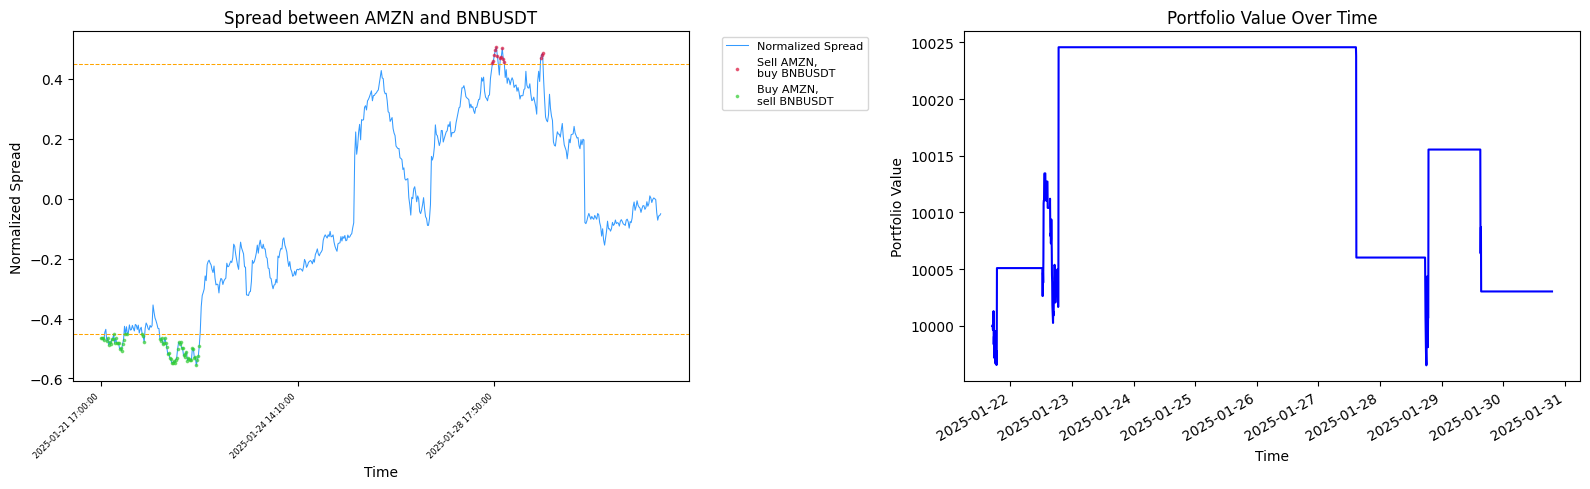

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=False)  # Disable shared y-axis

# Plot spread on ax1
data.plot_spread(ridge_test_df, tickerX, tickerY, s=s, ax=ax1)
ax1.set_title(f"Spread between {tickerX} and {tickerY}")

# Plot Portfolio Value on ax2
df_performance_AMZN_BNBUSDT['PortfolioValue'].plot(ax=ax2, legend=False, color='b')
ax2.set_title("Portfolio Value Over Time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Portfolio Value")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [13]:
df_performance_AMZN_BNBUSDT

,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB,PnL,PortfolioValue
OpenTime,,,,,,,,,,,,
2025-01-21 17:00:00,AMZN BNBUSDT,-0.465717,-0.444119,No action,AMZN,BNBUSDT,231.4300,231.39,693.00,692.90,0.000000,10000.000000
2025-01-21 17:05:00,AMZN BNBUSDT,-0.464872,-0.445716,No action,AMZN,BNBUSDT,231.1750,231.57,692.71,692.87,0.000000,10000.000000
2025-01-21 17:10:00,AMZN BNBUSDT,-0.464732,-0.441515,No action,AMZN,BNBUSDT,230.7608,231.43,692.29,693.00,0.000000,10000.000000
2025-01-21 17:15:00,AMZN BNBUSDT,-0.472963,-0.455286,Long AMZN / Short BNBUSDT,AMZN,BNBUSDT,230.6300,231.12,692.50,692.71,-0.351471,9999.648529
2025-01-21 17:20:00,AMZN BNBUSDT,-0.445911,-0.417436,No action,AMZN,BNBUSDT,230.5800,230.76,691.33,692.30,0.000000,9999.648529
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30 18:35:00,AMZN BNBUSDT,-0.046655,-0.127237,No action,AMZN,BNBUSDT,235.1600,235.87,679.38,678.17,0.000000,10003.024627
2025-01-30 18:40:00,AMZN BNBUSDT,-0.071533,-0.158104,No action,AMZN,BNBUSDT,234.7300,236.11,679.98,678.52,0.000000,10003.024627
2025-01-30 18:45:00,AMZN BNBUSDT,-0.057524,-0.081006,No action,AMZN,BNBUSDT,234.8300,235.15,679.50,679.38,0.000000,10003.024627


In [14]:
metrics_AMZN_BNBUSDT

,AMZN BNBUSDT
Metric,
Total Return,0.000302
Annualized Return,0.015900
Sharpe Ratio,0.008966
Sortino Ratio,0.012869
Hit Ratio,0.441860
Max Drawdown,0.002799
Portfolio Volatility,0.000401


In [15]:
print(f"Final portfolio value for '{p}' is ${final_portfolio_value:,.2f}, ~{(final_portfolio_value-initial_capital)/initial_capital*100:.2f}% increased.")

Final portfolio value for 'AMZN BNBUSDT' is $10,003.02, ~0.03% increased.


## SPY_ETF ETHUSDT

In [16]:
verbose = True

p = "SPY_ETF ETHUSDT"
i = 1
print(f"({i}) Pairs: {p}")
tickerX, tickerY = p.split(' ')

# 1. Read normalized features
df_norm = dict_data['df_norm'][p]
print(f'# of original features: {len(df_norm.columns)-1}')
print(f"Spread ranges from {df_norm['NormalizedSpread'].min():.4f} to {df_norm['NormalizedSpread'].max():.4f}\n")

s=0.35
# data.plot_spread(df_norm, tickerX, tickerY, s=s, ax=None)
# plt.show()

# 2. Create X, y based on LassoCV
lasso_features_cols = dict_cv_features[p]
target_col = df_norm.columns.tolist()[-1]
df_lasso = pd.concat([df_norm[lasso_features_cols], df_norm[target_col]], axis=1)
print(f'# of features after LassoCV: {len(df_lasso.columns)-1}')
print(f'features: {df_lasso.columns}')

# 3. Load train models and running the trainning process
ridge, ridge_mse, ridge_test_df, ridge_time, ridge_memory = models.ridge_regression(
    df=df_lasso, 
    p=p,
    s=s,
    pickle_file=os.path.join(dir_models_best, 'ridge', f"best_ridge_{p.replace(' ', '_')}.pkl"),
    testing=True,
    verbose=verbose,
)
# data.plot_spread(ridge_test_df, tickerX, tickerY, s=s, ax=None)
# plt.show()

print(f'\n')
display(ridge_test_df.PredictedSignal.value_counts())

df_strategy_SPY_ETHUSDT = Strategy.prepare_strategy_data(df_prices, ridge_test_df)
display(df_strategy_SPY_ETHUSDT)

(1) Pairs: SPY_ETF ETHUSDT
# of original features: 26
Spread ranges from -0.3901 to 0.4034

# of features after LassoCV: 15
features: Index(['SPY_ETF_EMA8', 'SPY_ETF_EMA21', 'SPY_ETF_MACD', 'SPY_ETF_BBupper',
       'SPY_ETF_BBmiddle', 'SPY_ETF_BBlower', 'SPY_ETF_ATR14', 'SPY_ETF_CCI20',
       'ETHUSDT_EMA8', 'ETHUSDT_EMA55', 'ETHUSDT_MACD', 'ETHUSDT_RSI14',
       'ETHUSDT_ATR14', 'ETHUSDT_StochD3', 'ETHUSDT_CCI20',
       'NormalizedSpread'],
      dtype='object')
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_SPY_ETF_ETHUSDT.pkl]
Ridge Regression MSE: 0.000499




PredictedSignal
No action                       528
Long SPY_ETF / Short ETHUSDT     23
Short SPY_ETF / Long ETHUSDT     19
Name: count, dtype: int64

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 17:00:00,SPY_ETF ETHUSDT,-0.199815,-0.188807,No action,SPY_ETF,ETHUSDT,602.570,602.450,3313.44,3310.54
1,2025-01-21 17:05:00,SPY_ETF ETHUSDT,-0.189785,-0.176162,No action,SPY_ETF,ETHUSDT,602.650,602.615,3309.01,3314.39
2,2025-01-21 17:10:00,SPY_ETF ETHUSDT,-0.190930,-0.178468,No action,SPY_ETF,ETHUSDT,602.555,602.565,3309.43,3313.45
3,2025-01-21 17:15:00,SPY_ETF ETHUSDT,-0.198926,-0.187314,No action,SPY_ETF,ETHUSDT,602.150,602.670,3312.62,3309.01
4,2025-01-21 17:20:00,SPY_ETF ETHUSDT,-0.187694,-0.175876,No action,SPY_ETF,ETHUSDT,602.090,602.560,3307.51,3309.43
...,...,...,...,...,...,...,...,...,...,...,...
565,2025-01-30 18:35:00,SPY_ETF ETHUSDT,-0.073596,-0.071852,No action,SPY_ETF,ETHUSDT,603.460,606.170,3257.58,3248.32
566,2025-01-30 18:40:00,SPY_ETF ETHUSDT,-0.105401,-0.109519,No action,SPY_ETF,ETHUSDT,602.070,606.285,3270.49,3251.48
567,2025-01-30 18:45:00,SPY_ETF ETHUSDT,-0.083916,-0.078133,No action,SPY_ETF,ETHUSDT,603.840,603.460,3262.60,3257.57
568,2025-01-30 18:50:00,SPY_ETF ETHUSDT,-0.086405,-0.083715,No action,SPY_ETF,ETHUSDT,604.951,602.090,3264.83,3270.49


### Run Strategy

In [17]:
initial_capital=10000
m_threshold=1
max_exposure=0.25
max_trade_size=1000
close_threshold=144

strat_2 = Strategy(
    initial_capital=initial_capital,
    m_threshold=m_threshold,
    max_exposure=max_exposure,
    max_trade_size=max_trade_size,
    close_threshold=close_threshold,
)

performance_SPY_ETHUSDT = strat_2.run_strategy(df_strategy_SPY_ETHUSDT)
final_portfolio_value = performance_SPY_ETHUSDT['Final Portfolio Value']
df_strategy_trades = pd.DataFrame(performance_SPY_ETHUSDT['Trades Executed']).rename(columns={"open_time": "OpenTime", "pnl": "PnL"})

metrics_SPY_ETHUSDT = (
    performance_SPY_ETHUSDT['Performance Metrics']
    .set_index('Metric')
    .rename(columns={"Value": p})
)

df_performance_SPY_ETHUSDT = (
    df_strategy_SPY_ETHUSDT.merge(df_strategy_trades[['OpenTime', 'PnL']], on='OpenTime', how='left')
    .fillna(0)
    .set_index('OpenTime')
)

df_performance_SPY_ETHUSDT['PortfolioValue'] = initial_capital + df_performance_SPY_ETHUSDT['PnL'].cumsum()

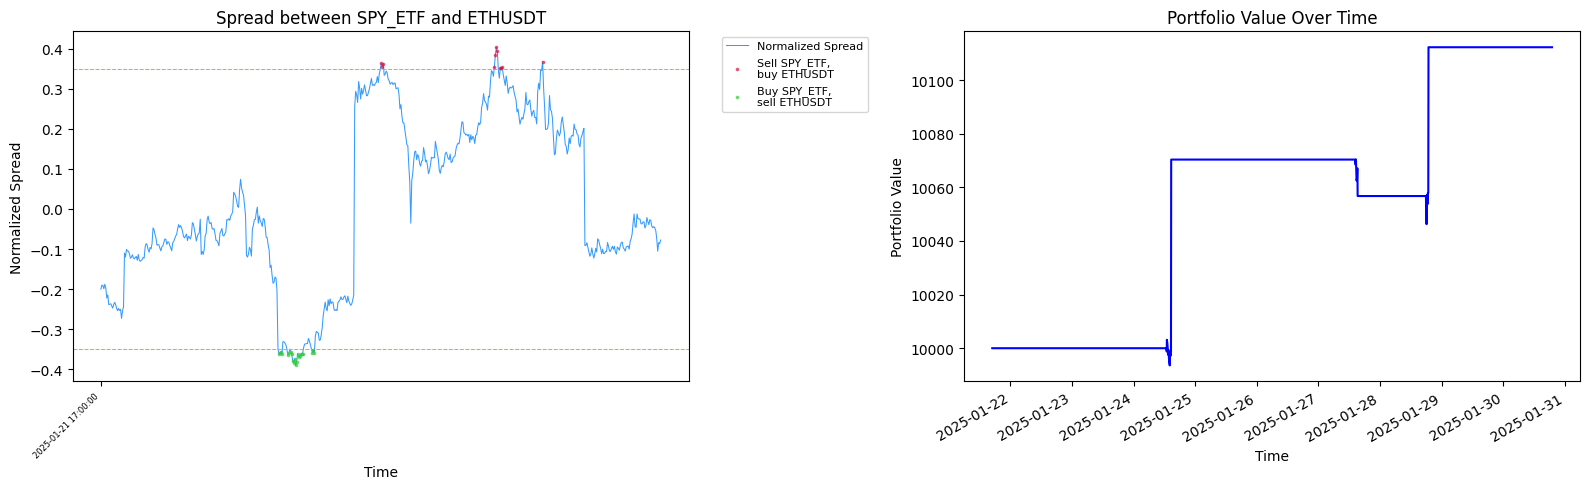

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=False)  # Disable shared y-axis

# Plot spread on ax1
data.plot_spread(ridge_test_df, tickerX, tickerY, s=s, ax=ax1)
ax1.set_title(f"Spread between {tickerX} and {tickerY}")

# Plot Portfolio Value on ax2
df_performance_SPY_ETHUSDT['PortfolioValue'].plot(ax=ax2, legend=False, color='b')
ax2.set_title("Portfolio Value Over Time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Portfolio Value")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [19]:
print(f"Final portfolio value for '{p}' is ${final_portfolio_value:,.2f}, {(final_portfolio_value-initial_capital)/initial_capital*100:.2f}% increased.")

Final portfolio value for 'SPY_ETF ETHUSDT' is $10,112.24, 1.12% increased.


In [20]:
df_performance_SPY_ETHUSDT

,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB,PnL,PortfolioValue
OpenTime,,,,,,,,,,,,
2025-01-21 17:00:00,SPY_ETF ETHUSDT,-0.199815,-0.188807,No action,SPY_ETF,ETHUSDT,602.570,602.450,3313.44,3310.54,0.0,10000.000000
2025-01-21 17:05:00,SPY_ETF ETHUSDT,-0.189785,-0.176162,No action,SPY_ETF,ETHUSDT,602.650,602.615,3309.01,3314.39,0.0,10000.000000
2025-01-21 17:10:00,SPY_ETF ETHUSDT,-0.190930,-0.178468,No action,SPY_ETF,ETHUSDT,602.555,602.565,3309.43,3313.45,0.0,10000.000000
2025-01-21 17:15:00,SPY_ETF ETHUSDT,-0.198926,-0.187314,No action,SPY_ETF,ETHUSDT,602.150,602.670,3312.62,3309.01,0.0,10000.000000
2025-01-21 17:20:00,SPY_ETF ETHUSDT,-0.187694,-0.175876,No action,SPY_ETF,ETHUSDT,602.090,602.560,3307.51,3309.43,0.0,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30 18:35:00,SPY_ETF ETHUSDT,-0.073596,-0.071852,No action,SPY_ETF,ETHUSDT,603.460,606.170,3257.58,3248.32,0.0,10112.237717
2025-01-30 18:40:00,SPY_ETF ETHUSDT,-0.105401,-0.109519,No action,SPY_ETF,ETHUSDT,602.070,606.285,3270.49,3251.48,0.0,10112.237717
2025-01-30 18:45:00,SPY_ETF ETHUSDT,-0.083916,-0.078133,No action,SPY_ETF,ETHUSDT,603.840,603.460,3262.60,3257.57,0.0,10112.237717


In [21]:
metrics_SPY_ETHUSDT

,SPY_ETF ETHUSDT
Metric,
Total Return,0.011099
Annualized Return,0.958035
Sharpe Ratio,0.191809
Sortino Ratio,1.300246
Hit Ratio,0.452381
Max Drawdown,0.002361
Portfolio Volatility,0.001375


In [22]:
df_metric = metrics_AMZN_BNBUSDT.join(metrics_SPY_ETHUSDT)
df_metric

,AMZN BNBUSDT,SPY_ETF ETHUSDT
Metric,,
Total Return,0.000302,0.011099
Annualized Return,0.015900,0.958035
Sharpe Ratio,0.008966,0.191809
Sortino Ratio,0.012869,1.300246
Hit Ratio,0.441860,0.452381
Max Drawdown,0.002799,0.002361
Portfolio Volatility,0.000401,0.001375


# Executed Strategy on all pairs

In [27]:
i = 1
verbose = False

tuned_performance = []
validation_dfs = pd.DataFrame()
s = 2.0

# Default Strategy Parameters
initial_capital = 10000
m_threshold = 1
max_exposure = 0.25
max_trade_size = 1000
close_threshold = 144

list_portfolio_value = []
list_metrics = []

for p in pairs:
    print(f"({i}) Pairs: {p}")
    tickerX, tickerY = p.split(' ')

    # 1. Read normalized features
    df_norm = dict_data['df_norm'][p]
    print(f'# of original features: {len(df_norm.columns)-1}')
    
    # 2. Create X, y based on LassoCV
    lasso_features_cols = dict_cv_features[p]
    target_col = df_norm.columns.tolist()[-1]
    df_lasso = pd.concat([df_norm[lasso_features_cols], df_norm[target_col]], axis=1)
    print(f'# of features after LassoCV: {len(df_lasso.columns)-1}')

    # 3. Load train models and running the trainning process
    ridge, ridge_mse, ridge_test_df, ridge_time, ridge_memory = models.ridge_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'ridge', f"best_ridge_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    df_strategy = Strategy.prepare_strategy_data(df_prices, ridge_test_df)
    display(df_strategy.head())
    
    xgb, xgb_mse, xgb_test_df, xgb_time, xgb_memory = models.xgboost_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'xgb', f"best_xgb_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    lstm, lstm_mse, lstm_test_df, lstm_time, lstm_memory = models.lstm_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'lstm', f"best_lstm_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    rnn, rnn_mse, rnn_test_df, rnn_time, rnn_memory = models.rnn_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'rnn', f"best_rnn_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )
    
    trf, trf_mse, trf_test_df, trf_time, trf_memory = models.transformer_regression(
        df=df_lasso, 
        p=p,
        pickle_file=os.path.join(dir_models_best, 'transformer', f"best_transformer_{p.replace(' ', '_')}.pkl"),
        testing=True,
        verbose=verbose,
    )

    validation_dfs = pd.concat([
        validation_dfs,
        ridge_test_df.reset_index(),
        xgb_test_df.reset_index(),
        lstm_test_df.reset_index(),
        rnn_test_df.reset_index(),
        trf_test_df.reset_index(),
    ])

    tuned_performance.append({
        'Pair': p,
        'Ridge Test MSE': ridge_mse,
        'Ridge Test Time': ridge_time,
        'Ridge Memory Usage': ridge_memory,
        'XGB Test MSE': xgb_mse,
        'XGB Test Time': xgb_time,
        'XGB Memory Usage': xgb_memory,
        'LSTM Test MSE': lstm_mse,
        'LSTM Test Time': lstm_time,
        'LSTM Memory Usage': lstm_memory,
        'RNN Test MSE': rnn_mse,
        'RNN Test Time': rnn_time,
        'RNN Memory Usage': rnn_memory,
        'Transformer Test MSE': trf_mse,
        'Transformer Test Time': trf_time,
        'Transformer Memory Usage': trf_memory,
    })

    i += 1

(1) Pairs: META DAXEX_ETF
# of original features: 26
# of features after LassoCV: 14
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/ridge/best_ridge_META_DAXEX_ETF.pkl]


,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-23 13:30:00,META DAXEX_ETF,1.158357,1.117652,No action,META,DAXEX_ETF,628.50,626.1400,177.52,177.62
1,2025-01-23 13:35:00,META DAXEX_ETF,1.179190,1.144523,No action,META,DAXEX_ETF,629.04,627.6001,177.66,177.54
2,2025-01-23 13:40:00,META DAXEX_ETF,1.131274,1.093460,No action,META,DAXEX_ETF,628.10,628.6399,177.64,177.54
3,2025-01-23 13:45:00,META DAXEX_ETF,1.134399,1.085757,No action,META,DAXEX_ETF,628.18,629.0200,177.66,177.64
4,2025-01-23 13:50:00,META DAXEX_ETF,1.079711,1.000706,No action,META,DAXEX_ETF,627.19,628.0000,177.72,177.66


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_META_DAXEX_ETF.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_META_DAXEX_ETF.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_META_DAXEX_ETF.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_META_DAXEX_ETF.pkl.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_META_DAXEX_ETF.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_META_DAXEX_ETF.pkl.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_META_DAXEX_ETF.p

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 17:00:00,AMZN BNBUSDT,-0.465717,-0.444119,No action,AMZN,BNBUSDT,231.4300,231.39,693.00,692.90
1,2025-01-21 17:05:00,AMZN BNBUSDT,-0.464872,-0.445716,No action,AMZN,BNBUSDT,231.1750,231.57,692.71,692.87
2,2025-01-21 17:10:00,AMZN BNBUSDT,-0.464732,-0.441515,No action,AMZN,BNBUSDT,230.7608,231.43,692.29,693.00
3,2025-01-21 17:15:00,AMZN BNBUSDT,-0.472963,-0.455286,No action,AMZN,BNBUSDT,230.6300,231.12,692.50,692.71
4,2025-01-21 17:20:00,AMZN BNBUSDT,-0.445911,-0.417436,No action,AMZN,BNBUSDT,230.5800,230.76,691.33,692.30


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_BNBUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_BNBUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_BNBUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_BNBUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_AMZN_BNBUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_AMZN_BNBUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_AMZN_BNBUSDT.pkl]
Loaded

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 17:00:00,AMZN TRXUSDT,1.431058,1.424312,No action,AMZN,TRXUSDT,231.4300,231.39,0.2429,0.2426
1,2025-01-21 17:05:00,AMZN TRXUSDT,1.413772,1.391713,No action,AMZN,TRXUSDT,231.1750,231.57,0.2428,0.2428
2,2025-01-21 17:10:00,AMZN TRXUSDT,1.385682,1.350995,No action,AMZN,TRXUSDT,230.7608,231.43,0.2428,0.2429
3,2025-01-21 17:15:00,AMZN TRXUSDT,1.376804,1.346586,No action,AMZN,TRXUSDT,230.6300,231.12,0.2429,0.2428
4,2025-01-21 17:20:00,AMZN TRXUSDT,1.373440,1.348307,No action,AMZN,TRXUSDT,230.5800,230.76,0.2425,0.2428


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_TRXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_AMZN_TRXUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_TRXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_AMZN_TRXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_AMZN_TRXUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_AMZN_TRXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_AMZN_TRXUSDT.pkl]
Loaded

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 17:00:00,SPY_ETF AVAXUSDT,1.988420,1.996713,No action,SPY_ETF,AVAXUSDT,602.570,602.450,37.06,36.97
1,2025-01-21 17:05:00,SPY_ETF AVAXUSDT,2.010764,2.036749,Short SPY_ETF / Long AVAXUSDT,SPY_ETF,AVAXUSDT,602.650,602.615,37.02,37.11
2,2025-01-21 17:10:00,SPY_ETF AVAXUSDT,2.007971,2.051405,Short SPY_ETF / Long AVAXUSDT,SPY_ETF,AVAXUSDT,602.555,602.565,36.94,37.06
3,2025-01-21 17:15:00,SPY_ETF AVAXUSDT,1.926977,1.895314,No action,SPY_ETF,AVAXUSDT,602.150,602.670,36.97,37.01
4,2025-01-21 17:20:00,SPY_ETF AVAXUSDT,1.936287,1.899876,No action,SPY_ETF,AVAXUSDT,602.090,602.560,36.86,36.95


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_AVAXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_AVAXUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_AVAXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_AVAXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_SPY_ETF_AVAXUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_SPY_ETF_AVAXUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 17:00:00,SPY_ETF ETHUSDT,-0.199815,-0.188807,No action,SPY_ETF,ETHUSDT,602.570,602.450,3313.44,3310.54
1,2025-01-21 17:05:00,SPY_ETF ETHUSDT,-0.189785,-0.176162,No action,SPY_ETF,ETHUSDT,602.650,602.615,3309.01,3314.39
2,2025-01-21 17:10:00,SPY_ETF ETHUSDT,-0.190930,-0.178468,No action,SPY_ETF,ETHUSDT,602.555,602.565,3309.43,3313.45
3,2025-01-21 17:15:00,SPY_ETF ETHUSDT,-0.198926,-0.187314,No action,SPY_ETF,ETHUSDT,602.150,602.670,3312.62,3309.01
4,2025-01-21 17:20:00,SPY_ETF ETHUSDT,-0.187694,-0.175876,No action,SPY_ETF,ETHUSDT,602.090,602.560,3307.51,3309.43


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_ETHUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_SPY_ETF_ETHUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_ETHUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_SPY_ETF_ETHUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_SPY_ETF_ETHUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_SPY_ETF_ETHUSDT.pkl.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_SPY_ET

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 13:40:00,EQQQ_ETF BNBUSDT,1.393149,1.395845,No action,EQQQ_ETF,BNBUSDT,42658.0,42728.0,693.37,691.58
1,2025-01-21 13:45:00,EQQQ_ETF BNBUSDT,1.404915,1.391207,No action,EQQQ_ETF,BNBUSDT,42673.0,42667.0,694.64,692.27
2,2025-01-21 13:55:00,EQQQ_ETF BNBUSDT,1.393286,1.378656,No action,EQQQ_ETF,BNBUSDT,42660.0,42673.0,695.21,694.65
3,2025-01-21 14:15:00,EQQQ_ETF BNBUSDT,1.423108,1.394599,No action,EQQQ_ETF,BNBUSDT,42695.0,42660.0,695.41,695.78
4,2025-01-21 14:25:00,EQQQ_ETF BNBUSDT,1.395248,1.375935,No action,EQQQ_ETF,BNBUSDT,42661.0,42728.0,693.92,695.42


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_EQQQ_ETF_BNBUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_EQQQ_ETF_BNBUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_EQQQ_ETF_BNBUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_EQQQ_ETF_BNBUSDT.pkl.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_EQQQ_ETF_BNBUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_EQQQ_ETF_BNBUSDT.pkl.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 00:30:00,BNBUSDT ADAUSDT,0.519819,0.513112,No action,BNBUSDT,ADAUSDT,678.56,682.17,0.9793,0.9901
1,2025-01-21 00:35:00,BNBUSDT ADAUSDT,0.529483,0.522528,No action,BNBUSDT,ADAUSDT,679.10,681.68,0.9791,0.9878
2,2025-01-21 00:40:00,BNBUSDT ADAUSDT,0.546760,0.542329,No action,BNBUSDT,ADAUSDT,680.07,678.57,0.9834,0.9793
3,2025-01-21 00:45:00,BNBUSDT ADAUSDT,0.554593,0.551310,No action,BNBUSDT,ADAUSDT,680.51,679.11,0.9856,0.9791
4,2025-01-21 00:50:00,BNBUSDT ADAUSDT,0.557049,0.552909,No action,BNBUSDT,ADAUSDT,680.65,680.08,0.9883,0.9834


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_ADAUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_ADAUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_ADAUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_ADAUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_ADAUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_ADAUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_BNBU

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 00:30:00,BNBUSDT BTCUSDT,-1.059534,-1.077299,No action,BNBUSDT,BTCUSDT,678.56,682.17,102096.00,102800.95
1,2025-01-21 00:35:00,BNBUSDT BTCUSDT,-1.068544,-1.073894,No action,BNBUSDT,BTCUSDT,679.10,681.68,102225.48,102716.60
2,2025-01-21 00:40:00,BNBUSDT BTCUSDT,-1.076011,-1.073470,No action,BNBUSDT,BTCUSDT,680.07,678.57,102333.31,102096.00
3,2025-01-21 00:45:00,BNBUSDT BTCUSDT,-1.079662,-1.073553,No action,BNBUSDT,BTCUSDT,680.51,679.11,102386.00,102225.48
4,2025-01-21 00:50:00,BNBUSDT BTCUSDT,-1.083801,-1.075032,No action,BNBUSDT,BTCUSDT,680.65,680.08,102445.37,102333.32


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_BTCUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_BTCUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_BTCUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_BTCUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_BTCUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_BTCUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_BNBU

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 00:30:00,BNBUSDT TRXUSDT,0.521131,0.513937,No action,BNBUSDT,TRXUSDT,678.56,682.17,0.2371,0.2393
1,2025-01-21 00:35:00,BNBUSDT TRXUSDT,0.530751,0.522761,No action,BNBUSDT,TRXUSDT,679.10,681.68,0.2371,0.2391
2,2025-01-21 00:40:00,BNBUSDT TRXUSDT,0.548026,0.542374,No action,BNBUSDT,TRXUSDT,680.07,678.57,0.2374,0.2371
3,2025-01-21 00:45:00,BNBUSDT TRXUSDT,0.555858,0.551335,No action,BNBUSDT,TRXUSDT,680.51,679.11,0.2378,0.2370
4,2025-01-21 00:50:00,BNBUSDT TRXUSDT,0.558341,0.552982,No action,BNBUSDT,TRXUSDT,680.65,680.08,0.2384,0.2373


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_TRXUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_TRXUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_TRXUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_TRXUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_TRXUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_TRXUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_BNBU

,OpenTime,Pair,NormalizedSpread,PredictedSpread,PredictedSignal,AssetA,AssetB,CloseA,NextOpenA,CloseB,NextOpenB
0,2025-01-21 00:30:00,BNBUSDT XRPUSDT,0.501703,0.495376,No action,BNBUSDT,XRPUSDT,678.56,682.17,3.0612,3.0812
1,2025-01-21 00:35:00,BNBUSDT XRPUSDT,0.511539,0.504148,No action,BNBUSDT,XRPUSDT,679.10,681.68,3.0568,3.0811
2,2025-01-21 00:40:00,BNBUSDT XRPUSDT,0.528767,0.524947,No action,BNBUSDT,XRPUSDT,680.07,678.57,3.0732,3.0613
3,2025-01-21 00:45:00,BNBUSDT XRPUSDT,0.537015,0.532673,No action,BNBUSDT,XRPUSDT,680.51,679.11,3.0567,3.0568
4,2025-01-21 00:50:00,BNBUSDT XRPUSDT,0.539353,0.534635,No action,BNBUSDT,XRPUSDT,680.65,680.08,3.0673,3.0732


Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_XRPUSDT.pkl]
Loaded XGBoost model from /home/alfred/projects/mscfe-masters-project/src/models/best/xgb/best_xgb_BNBUSDT_XRPUSDT.pkl.
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_XRPUSDT.pkl]
Loaded LSTM model from /home/alfred/projects/mscfe-masters-project/src/models/best/lstm/best_lstm_BNBUSDT_XRPUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_XRPUSDT.pkl]
Loaded RNN model from /home/alfred/projects/mscfe-masters-project/src/models/best/rnn/best_rnn_BNBUSDT_XRPUSDT.pkl.
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   
Testing Phase
[pypickle] Pickle file loaded: [/home/alfred/projects/mscfe-masters-project/src/models/best/transformer/best_transformer_BNBU

In [29]:
validation_dfs = validation_dfs.reset_index(drop=True)

# Create a column with Next Opening Price for trading strategy execution
df_temp = (df_full
           .groupby(by=['Symbol', 'OpenTime'])
           .agg({'Open': 'first',
                 'Close': 'first'})
           .reset_index())
df_temp['OpenTime'] = pd.to_datetime(df_temp['OpenTime'])
df_temp = df_temp.sort_values(by=['Symbol', 'OpenTime'])
df_temp = (df_temp
           .groupby(by=['Symbol'], group_keys=False)
           # Shift open prices within each symbol
           .apply(lambda x: x.assign(NextOpen=x['Open'].shift(1)))
           .reset_index(level=0, drop=True))
performances = {}

for model in validation_dfs['Model'].unique().tolist():
    # Prepare dataframe for model-based strategy testing
    model_df = (validation_dfs[validation_dfs['Model']==model]
                .sort_index()
                .sort_values(by='Pair')
                [['OpenTime',
                  'Pair',
                  'NormalizedSpread',
                  'PredictedSpread',
                  'PredictedSignal']])
    model_df['OpenTime'] = pd.to_datetime(model_df['OpenTime'])
    model_df[['AssetA', 'AssetB']] = model_df['Pair'].str.split(' ', n=1, expand=True)
    model_df = (pd.merge(left=model_df,
                         right=df_temp[['OpenTime', 'Symbol', 'NextOpen', 'Close']],
                         left_on=['OpenTime', 'AssetA'],
                         right_on=['OpenTime', 'Symbol'],
                         how='left')
                .drop(['Symbol'], axis=1))
    model_df = model_df.rename(columns={'NextOpen':'NextOpenA',
                                        'Close':'CloseA'})
    model_df = (pd.merge(left=model_df,
                         right=df_temp[['OpenTime', 'Symbol', 'NextOpen', 'Close']],
                         left_on=['OpenTime', 'AssetB'],
                         right_on=['OpenTime', 'Symbol'],
                         how='left')
                .drop(['Symbol'], axis=1))
    model_df = model_df.rename(columns={'NextOpen':'NextOpenB',
                                        'Close':'CloseB'})
    # Test the strategy
    strategy_baseline = Strategy()
    performance = strategy_baseline.run_strategy(model_df)
    performances[model] = performance
    log.info(f'Portfolio metrics for model {model} calculated correctly.')

metrics_list = []

for model, perf in performances.items():
    if 'Performance Metrics' in perf and isinstance(perf['Performance Metrics'], pd.DataFrame):
        df_metrics = perf['Performance Metrics'].copy()
        df_metrics['Model'] = model
        metrics_list.append(df_metrics)

performance_df = pd.concat(metrics_list, ignore_index=True)
performance_df = performance_df[['Model', 'Metric', 'Value']]
performance_df = pd.pivot_table(performance_df,
                                index='Metric',
                                columns='Model',
                                values='Value')
display(performance_df)

/tmp/ipykernel_16783/2782256013.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(NextOpen=x['Open'].shift(1)))


Model,LSTM,RNN,Ridge Regression,Transformer,XGBoost
Metric,,,,,
Annualized Return,-0.361329,-0.412717,-0.272774,-0.271337,0.161141
Hit Ratio,0.505190,0.503484,0.497561,0.505747,0.463415
Max Drawdown,0.016536,0.018524,0.019192,0.015753,0.004190
Portfolio Volatility,0.000491,0.000476,0.000517,0.000466,0.000629
Sharpe Ratio,-0.038644,-0.047728,-0.024411,-0.038234,0.016187
Sortino Ratio,-0.043086,-0.052183,-0.030374,-0.041133,0.049416
Total Return,-0.010987,-0.013029,-0.007818,-0.007770,0.000409
